# Tutorial: Recursive Language Models (RLM)

This tutorial demonstrates **Recursive Language Models (RLM)**, an inference strategy where LLMs treat long contexts as part of an external environment rather than feeding them directly to the model. The LLM writes Python code to programmatically examine, decompose, and recursively call sub-LLMs over snippets.

Reference: ["Recursive Language Models" (Zhang, Kraska, Khattab, 2025)](https://arxiv.org/abs/placeholder)

We'll evaluate RLM on the [Oolong benchmark](https://huggingface.co/datasets/oolongbench/oolong-synth), which tests long context reasoning and aggregation capabilities.

Install dependencies: `pip install dspy datasets`

## Setup

Configure DSPy with an LLM. RLM uses this LLM both for generating code and for the `llm_query()` tool inside the sandbox.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dspy

lm = dspy.LM("openai/gpt-5")
dspy.configure(lm=lm)

/Users/isaac/Projects/dspy-worktrees/isaac/isaac/dspy-rlm/.venv/lib/python3.14/site-packages/openai/_compat.py:48: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.typing import (


In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pydantic')


## Load the Oolong Dataset

Oolong is a benchmark for evaluating long context reasoning and aggregation. Tasks include counting labels, finding needles in haystacks, and comparing frequencies.

The dataset has two splits with different source datasets:
- **validation** (1,300 examples): `spam` (650), `trec_coarse` (650)
- **test** (5,200 examples): `agnews`, `app_reviews`, `formality`, `imdb`, `metaphors`, `multinli`, `negation`, `yahoo` (650 each)

In [4]:
from datasets import load_dataset
from collections import Counter

# Load both splits
dataset = load_dataset("oolongbench/oolong-synth")
val_data = dataset["validation"]
test_data = dataset["test"]

print(f"Validation: {len(val_data)} examples")
print(f"  Datasets: {dict(Counter(val_data['dataset']))}")

print(f"\nTest: {len(test_data)} examples")
print(f"  Datasets: {dict(Counter(test_data['dataset']))}")

Resolving data files:   0%|          | 0/42 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/42 [00:00<?, ?it/s]

Validation: 1300 examples
  Datasets: {'spam': 650, 'trec_coarse': 650}

Test: 5200 examples
  Datasets: {'metaphors': 650, 'negation': 650, 'formality': 650, 'imdb': 650, 'app_reviews': 650, 'yahoo': 650, 'multinli': 650, 'agnews': 650}


## Prepare Examples for Evaluation

Convert the dataset to `dspy.Example` format, organized by source dataset.

In [5]:
import random
random.seed(42)

def make_example(row):
    return dspy.Example(
        id=row["id"],
        context_window_id=row.get("context_window_id"),
        context=row["context_window_text"],
        query=row["question"],
        answer=row["answer"],
        task=row.get("task", "unknown"),
        answer_type=row.get("answer_type", "LABEL"),
        dataset=row.get("dataset", "unknown"),
        context_len=row.get("context_len", len(row["context_window_text"])),
    ).with_inputs("context", "query")

# Separate validation by source dataset
val_spam = [make_example(row) for row in val_data if row["dataset"] == "spam"]
val_trec = [make_example(row) for row in val_data if row["dataset"] == "trec_coarse"]

# IMPORTANT: Shuffle before splitting! The dataset is ordered by context_len,
# so without shuffling, devset would only contain the shortest (easiest) examples.
random.shuffle(val_spam)
random.shuffle(val_trec)

# For each validation dataset: first 50 as dev, rest as val
devset_spam, valset_spam = val_spam[:50], val_spam[50:]
devset_trec, valset_trec = val_trec[:50], val_trec[50:]

# Combined devset and valset
devset = devset_spam + devset_trec
valset = valset_spam + valset_trec

# Separate test by source dataset
test_by_dataset = {}
for row in test_data:
    ds_name = row["dataset"]
    if ds_name not in test_by_dataset:
        test_by_dataset[ds_name] = []
    test_by_dataset[ds_name].append(make_example(row))

# Full testset (also shuffle for fair sampling)
testset = [make_example(row) for row in test_data]
random.shuffle(testset)

print("Validation splits (shuffled by context_len):")
print(f"  devset_spam: {len(devset_spam)}, valset_spam: {len(valset_spam)}")
print(f"  devset_trec: {len(devset_trec)}, valset_trec: {len(valset_trec)}")
print(f"  devset (combined): {len(devset)}, valset (combined): {len(valset)}")

# Show context_len distribution in devset to verify shuffling worked
from collections import Counter
devset_lens = Counter(ex.context_len for ex in devset)
print(f"\n  devset context_len distribution: {dict(sorted(devset_lens.items()))}")

print(f"\nTest splits:")
for name, examples in sorted(test_by_dataset.items()):
    print(f"  {name}: {len(examples)}")
print(f"  testset (combined): {len(testset)}")

Validation splits (shuffled by context_len):
  devset_spam: 50, valset_spam: 600
  devset_trec: 50, valset_trec: 600
  devset (combined): 100, valset (combined): 1200

  devset context_len distribution: {1024: 11, 2048: 9, 4096: 9, 8192: 9, 16384: 8, 32768: 3, 65536: 10, 131072: 4, 262144: 13, 524288: 7, 1048576: 7, 2097152: 4, 4194304: 6}

Test splits:
  agnews: 650
  app_reviews: 650
  formality: 650
  imdb: 650
  metaphors: 650
  multinli: 650
  negation: 650
  yahoo: 650
  testset (combined): 5200


## Define the Metric

The metric matches the [official Oolong benchmark evaluation](https://github.com/abertsch72/oolong/blob/main/src/eval/eval_helpers.py):
- Parses answers by taking text after the last `:`
- Exact string matching for labels
- Partial credit for numeric answers: `0.75 ** abs(gold - predicted)`
- Special handling for comparison answers ("more common", "less common", "same frequency")

In [6]:
import re
import ast

def parse_answer(answer: str) -> tuple[str, str]:
    """Parse model answer, returning (parsed_answer, confidence).
    
    Matches the official Oolong benchmark parsing logic.
    """
    parse_confidence = "low"
    
    if ":" not in answer:
        if len(answer) < 20:
            return answer, parse_confidence
        else:
            return answer.split()[-1], parse_confidence
    
    # Take text after last ":"
    candidate = answer.split(":")[-1].strip()
    
    # Remove markdown bolding and brackets
    candidate = candidate.replace("*", "")
    candidate = candidate.replace("[", "").replace("]", "")
    
    parse_confidence = "med"
    
    # Higher confidence if answer follows expected format
    if any(marker in answer for marker in ["User:", "Answer:", "Date:", "Label"]):
        parse_confidence = "high"
    
    if len(candidate) < 20:
        parse_confidence = "vhigh"
    elif "more common" in candidate:
        candidate = "more common"
    elif "less common" in candidate:
        candidate = "less common"
    elif "same frequency" in candidate:
        candidate = "same frequency"
    
    return candidate, parse_confidence


def oolong_metric(example, pred, trace=None):
    """Official Oolong benchmark metric with partial credit for numeric answers."""
    
    # Parse gold answer
    expected = example.answer
    if isinstance(expected, list):
        gold = str(expected[0])
    else:
        expected_str = str(expected).strip()
        if expected_str.startswith("[") and expected_str.endswith("]"):
            try:
                parsed = ast.literal_eval(expected_str)
                gold = str(parsed[0]) if isinstance(parsed, list) else expected_str
            except:
                gold = expected_str
        else:
            gold = expected_str
    
    # Parse model answer
    trimmed_output, _ = parse_answer(pred.answer)
    
    # Exact match
    if str(trimmed_output).strip().lower() == str(gold).strip().lower():
        return 1.0
    
    # Comparison answers (more/less/same common)
    if trimmed_output in ["more common", "less common", "same frequency"]:
        if trimmed_output in str(gold).lower():
            return 1.0
    
    # Numeric: partial credit with exponential decay
    answer_type = getattr(example, "answer_type", "")
    if answer_type == "ANSWER_TYPE.NUMERIC" or answer_type == "NUMERIC":
        try:
            pred_num = int(trimmed_output)
            gold_num = int(gold)
            return 0.75 ** abs(gold_num - pred_num)
        except (ValueError, TypeError):
            pass
    
    return 0.0

## Initialize RLM

RLM executes in a secure Deno/Pyodide/WASM sandbox. The LLM can:
- Access the `context` variable containing the input data
- Call `llm_query(prompt)` to query a sub-LLM for semantic analysis
- Use standard Python libraries (re, json, collections, etc.)
- Build up answers iteratively through multiple code executions

In [7]:
def llm_query_nano(prompt: str = "") -> str:
    """Query gpt-5-nano with a prompt."""
    if not prompt:
        raise ValueError("prompt is required")
    nano = dspy.LM("openai/gpt-5-nano")
    response = nano(prompt)
    return response[0] if isinstance(response, list) else str(response)

In [8]:
from dspy.predict.rlm import RLM

rlm = RLM("context, query -> answer", max_iterations=20, sub_lm=dspy.LM("openai/gpt-5-nano"), verbose=True)

## Run Evaluation on Devset

Use `dspy.Evaluate` to run RLM on the devset with parallelism. For full evaluation, replace `devset` with `valset` or `testset`.

In [ ]:
# Available splits: devset_spam, devset_trec, valset_spam, valset_trec, test_by_dataset[name], testset
dspy.configure(lm=dspy.LM("openai/gpt-5"))

# Use the pre-shuffled devset (now includes mixed context lengths)
current_devset = devset_trec[:20]

evaluate = dspy.Evaluate(
    devset=current_devset,
    metric=oolong_metric,
    num_threads=10,
    display_progress=True,
    display_table=10,
    provide_traceback=True,
)

results = evaluate(rlm)

# Show results with context_len breakdown
print("\nOolong RLM Evaluation Results:")
print(f"Split: devset_trec (shuffled), {len(current_devset)} examples")
print(f"  LLM: {dspy.settings.lm.model}")
print(f"  Alex RLM: 56.5%")
print(f"  DSPy RLM: {results.score:.2f}%")

avg_trajectory_length = sum(len(r[1].trajectory) for r in results.results) / len(results.results)
print(f"  Avg trajectory length: {avg_trajectory_length:.2f}")

  Avg trajectory length: 1.00


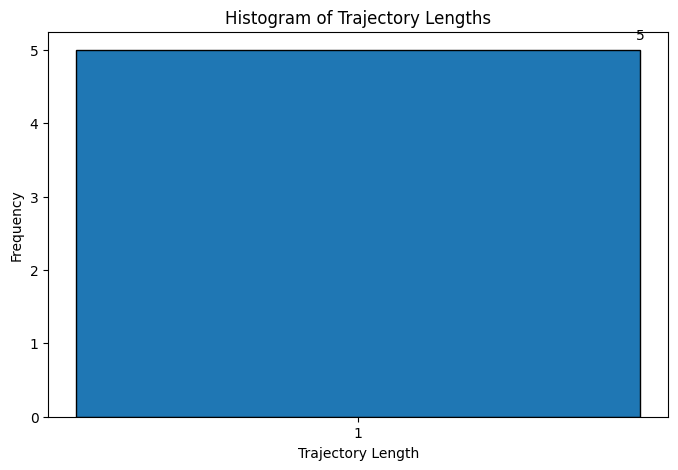

In [ ]:
avg_trajectory_length = sum(len(result[1].trajectory) for result in results.results) / len(results.results)
print(f"  Avg trajectory length: {avg_trajectory_length:.2f}")

import matplotlib.pyplot as plt

# Collect all trajectory lengths
trajectory_lengths = [len(result[1].trajectory) for result in results.results]

plt.figure(figsize=(8, 5))
counts, bins, patches = plt.hist(
    trajectory_lengths,
    bins=range(1, max(trajectory_lengths) + 2),
    edgecolor='black',
    align='left'
)
plt.xlabel('Trajectory Length')
plt.ylabel('Frequency')
plt.title('Histogram of Trajectory Lengths')
plt.xticks(range(1, max(trajectory_lengths)+1))

# Add counts above each bar
for count, bin_left, patch in zip(counts, bins[:-1], patches):
    if count > 0:
        plt.text(
            bin_left + patch.get_width() / 2,
            count + 0.02 * max(counts),  # A little above the bar
            f"{int(count)}",
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.show()



## Inspect a Single Trajectory

Let's run RLM on one example and examine the trajectory (the sequence of code executions).

In [ ]:
# for i, ex in enumerate(current_devset):
    #   print(f"{i}: context_len={ex.context_len:,} tokens")

0: context_len=131,072 tokens
1: context_len=32,768 tokens
2: context_len=2,048 tokens
3: context_len=1,024 tokens
4: context_len=262,144 tokens
5: context_len=16,384 tokens
6: context_len=262,144 tokens
7: context_len=16,384 tokens
8: context_len=4,194,304 tokens
9: context_len=65,536 tokens
10: context_len=4,096 tokens
11: context_len=8,192 tokens
12: context_len=65,536 tokens
13: context_len=524,288 tokens
14: context_len=2,048 tokens
15: context_len=2,048 tokens
16: context_len=524,288 tokens
17: context_len=262,144 tokens
18: context_len=8,192 tokens
19: context_len=1,024 tokens
20: context_len=65,536 tokens
21: context_len=4,096 tokens
22: context_len=2,097,152 tokens
23: context_len=8,192 tokens
24: context_len=4,194,304 tokens
25: context_len=65,536 tokens
26: context_len=131,072 tokens
27: context_len=2,048 tokens
28: context_len=131,072 tokens
29: context_len=4,194,304 tokens
30: context_len=2,048 tokens
31: context_len=4,096 tokens
32: context_len=524,288 tokens
33: context_

In [13]:
example = current_devset[8]
print(example.context_len)

def print_trajectory(trajectory):
    """Pretty-print an RLM trajectory."""
    for i, step in enumerate(trajectory):
        print(f"\n{'='*60}")
        print(f"Step {i+1}")
        print(f"{'='*60}")
        
        if step.get("reasoning"):
            reasoning = step['reasoning']
            print(f"\nReasoning: {reasoning}")
        
        print(f"\nCode:")
        print(f"```python")
        print(step["code"])
        print(f"```")
        
        print(f"\nOutput:")
        output = step["output"]
        if len(output) > 500:
            print(output[:500] + "\n... (truncated)")
        else:
            print(output if output else "(no output)")

print(f"Query: {example.query}")
print(f"Expected: {example.answer}")
print(f"Context length: {len(example.context):,} chars, First 100 chars: {example.context[:100]}")
print("\nRunning RLM...")

gpt5 = dspy.LM("openai/gpt-5")
dspy.configure(lm=gpt5)

from dspy.predict.rlm import RLM

rlm = RLM("context, query -> answer", max_iterations=10, verbose=True)

result = rlm(context=example.context, query=example.query)

print_trajectory(result.trajectory)

2026/01/06 22:29:46 INFO dspy.predict.rlm: RLM iteration 1/10
2026/01/06 22:29:47 INFO dspy.predict.rlm: Reasoning: STEP 1 - EXPLORE: I will inspect the structure of `context`, print its length, show a small head sam...


4194304
Query: In the above data, is label 'location' more common, less common, or the same frequency as label 'human being'? Give your final answer in the form 'Answer: location is [X] human being', where [X] is 'more common than', 'less common than', or 'same frequency as'.
Expected: ['more common than']
Context length: 9,874,323 chars, First 100 chars: The following lines contain 102158 general-knowledge questions, one per line. Each question has an a

Running RLM...


2026/01/06 22:29:48 INFO dspy.predict.rlm: Executed code, output: Type of context: str
Length of context: 9874323
Preview of first 1000 chars:
 The following lines contain 102158 general-knowledge questions, one per line. Each question has an answer that can be desc...
2026/01/06 22:29:48 INFO dspy.predict.rlm: RLM iteration 2/10
2026/01/06 22:29:48 INFO dspy.predict.rlm: Reasoning: STEP 2 - ANALYZE: I will search the context to locate how labels are encoded per line (e.g., "|| Lab...
2026/01/06 22:29:49 INFO dspy.predict.rlm: Executed code, output: Data starts at line index: 4
Total data lines (raw): 102162
Found 'Label:' occurrences in first 5000 data lines: 0
Sample 'Label:' lines (last 200 chars and captured label): []
Found bracket tag occur...
2026/01/06 22:29:49 INFO dspy.predict.rlm: RLM iteration 3/10
2026/01/06 22:29:49 INFO dspy.predict.rlm: Reasoning: What I know:
- context is a very large string (~9.87M chars) with 102,158 question lines after a bri...
2026/01/06 22:29:54 


Step 1

Reasoning: STEP 1 - EXPLORE: I will inspect the structure of `context`, print its length, show a small head sample of the raw text, and print the first few lines to understand the line format and how labels are encoded. I will not compute or answer yet.

Code:
```python
# STEP 1 - EXPLORE
print("Type of context:", type(context).__name__)
print("Length of context:", len(context))
print("Preview of first 1000 chars:\n", context[:1000])

# Show the first 40 lines (truncated per line) to inspect formatting
lines = context.splitlines()
print("\nNumber of lines (including header and data):", len(lines))
for i, line in enumerate(lines[:40]):
    print(f"{i:02d}: {repr(line[:200])}")

print("\nQuery:", query)

# Note: Not answering yet; only exploring.
```

Output:
Type of context: str
Length of context: 9874323
Preview of first 1000 chars:
 The following lines contain 102158 general-knowledge questions, one per line. Each question has an answer that can be described as one of 6 categ

## Visualize the Trajectory

The trajectory shows each iteration: the code executed and the output received.

In [ ]:


# print_trajectory(result.trajectory)

## When to Use RLM

RLM is particularly useful when:

1. **Long contexts**: The context is too large to fit in the LLM's context window, or would be expensive to process directly
2. **Aggregation tasks**: You need to count, compare, or aggregate information across a large document
3. **Structured data**: The context has structure (JSON, tables, sections) that can be programmatically navigated
4. **Iterative exploration**: The answer requires examining the data from multiple angles

The key insight is that LLMs can write code to efficiently process data, calling back to sub-LLMs only when semantic understanding is needed.